In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from livelossplot import PlotLossesKerasTF

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(1234)
 
import datasets
import losses
import models
import build

In [2]:
base, trainable = models.VGG16()

In [3]:
dataset, n = datasets.SCUTFBP5500(input_shape=base.input_shape)
#dataset, n = datasets.MEBeauty(input_shape=base.input_shape)
dataset.generate(model=base, augment=0)

KeyboardInterrupt: 

In [ ]:
model = build.build(
    base.output_shape,
    trainable=trainable,
    n=n,
    augment=False,
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 1, 1, 512)         7079424   
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                      

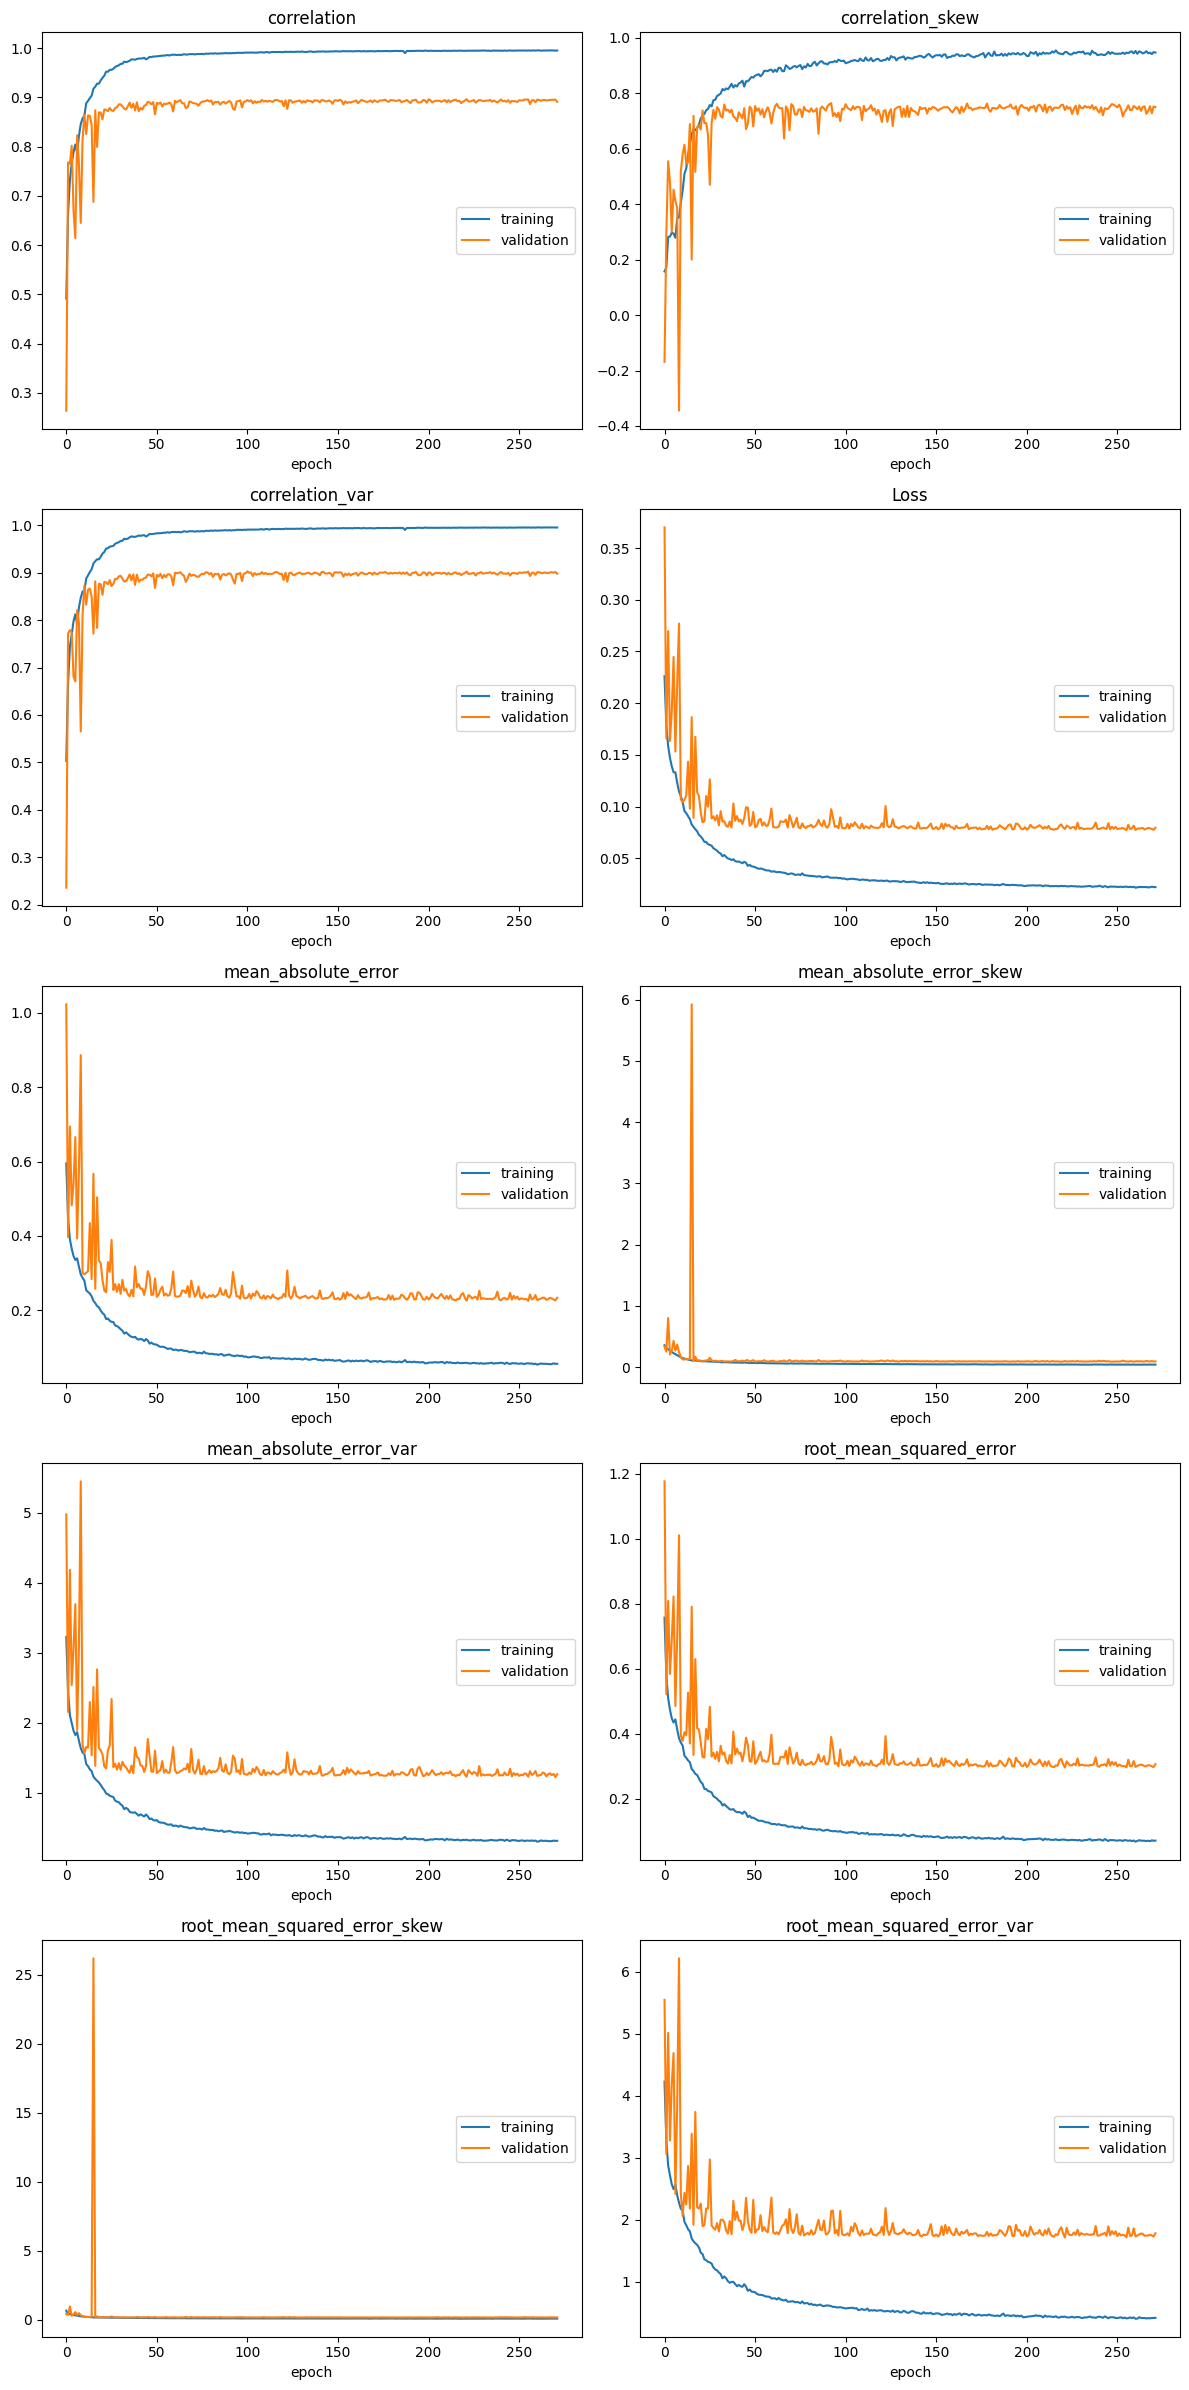

correlation
	training         	 (min:    0.491, max:    0.995, cur:    0.995)
	validation       	 (min:    0.264, max:    0.896, cur:    0.891)
correlation_skew
	training         	 (min:    0.157, max:    0.954, cur:    0.946)
	validation       	 (min:   -0.345, max:    0.764, cur:    0.750)
correlation_var
	training         	 (min:    0.503, max:    0.995, cur:    0.995)
	validation       	 (min:    0.236, max:    0.903, cur:    0.898)
Loss
	training         	 (min:    0.021, max:    0.226, cur:    0.022)
	validation       	 (min:    0.077, max:    0.370, cur:    0.079)
mean_absolute_error
	training         	 (min:    0.053, max:    0.595, cur:    0.056)
	validation       	 (min:    0.225, max:    1.023, cur:    0.234)
mean_absolute_error_skew
	training         	 (min:    0.042, max:    0.359, cur:    0.044)
	validation       	 (min:    0.091, max:    5.922, cur:    0.096)
mean_absolute_error_var
	training         	 (min:    0.299, max:    3.226, cur:    0.312)
	validation       	 (mi

16.57669628499995

In [ ]:
metrics = [losses.MeanAbsoluteError(n=n),
           losses.RootMeanSquaredError(n=n),
           losses.PearsonCorrelation(n=n),
           losses.MeanAbsoluteError(n=n, mode="var"),
           losses.RootMeanSquaredError(n=n, mode="var"),
           losses.PearsonCorrelation(n=n, mode="var"),
           losses.MeanAbsoluteError(n=n, mode="skew"),
           losses.RootMeanSquaredError(n=n, mode="skew"),
           losses.PearsonCorrelation(n=n, mode="skew")]

#loss = tf.keras.losses.MeanSquaredError()
#loss = tf.keras.losses.CategoricalCrossentropy()
loss = losses.SquaredEarthMoversDistance()

#dataset.shuffle()
build.compile(model, loss, metrics=metrics, learning_rate=0.0006)
time = build.train(
    model, 
    dataset.train, 
    dataset.test,
    monitor="val_correlation",
    callbacks=[PlotLossesKerasTF()]
)

print(f"Time: {np.round(time, 4)}")

In [ ]:
np.round(model.evaluate(dataset.test), 6)

69/69 [==============================] - 1s 8ms/step - loss: 0.0782 - mean_absolute_error: 0.2255 - root_mean_squared_error: 0.2968 - correlation: 0.8962 - mean_absolute_error_var: 1.2280 - root_mean_squared_error_var: 1.7136 - correlation_var: 0.9022 - mean_absolute_error_skew: 0.1025 - root_mean_squared_error_skew: 0.1782 - correlation_skew: 0.7392


array([0.078192, 0.225495, 0.2968  , 0.896174, 1.227989, 1.713554,
       0.902215, 0.102506, 0.178161, 0.739175])